In [1]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch
import torch.nn as nn
import random, glob, os
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
df = pd.read_csv('../smiles_selfies_full.csv')

### Tokenization

In [3]:
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def tokens_to_ids(tokens, tok2id):
    return np.array([tok2id[t] for t in tokens])

df['token_ids'] = df['tokens'].apply(lambda toks: tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

### Data prep

In [10]:
sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences) + 1
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq
    padded_data[i, len(seq)] = 2 # <EOS> token

data = padded_data
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)
print(max_len)

76


### Model

In [12]:
class BaselineVAE(nn.Module):
    def __init__(self, vocab_size, max_len, embed_size=64, hidden_size=128, latent_size=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.start_T = 5
        self.max_len = max_len

        self.encoder = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=5, padding=2, dilation=1),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=4, dilation=2),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=8, dilation=4),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=16, dilation=8),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=32, dilation=8),
            nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        self.fc_z = nn.Linear(latent_size, hidden_size * self.start_T)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, kernel_size=7, stride=1, padding=3)
        )        
        self.output_fc = nn.Linear(hidden_size, vocab_size)

    def encode(self, x):
        h = self.embed(x).transpose(1,2)
        h = self.encoder(h)
        h = self.pool(h).squeeze(-1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def decode(self, z):
        B = z.size(0)
        h = self.fc_z(z)
        h = h.view(B, self.hidden_size, self.start_T)
        h = self.decoder(h)            # [B, H, T]
        h = h[:, :, :self.max_len]
        logits = self.output_fc(h.transpose(1, 2))  # [B, T, vocab]
        return logits
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        logits = self.decode(z)
        return logits, mu, logvar
    
    def encode_sequence(self, x, batch_size=256):
        self.eval()
        device = next(self.parameters()).device
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.long)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        loader = DataLoader(TensorDataset(x), batch_size=batch_size)
        logits_list, mu_list, logvar_list = [], [], []
        with torch.no_grad():
            for (bx,) in loader:
                bx = bx.to(device)
                logits, mu, logvar = self(bx)
                mu_list.append(mu.cpu())
                logvar_list.append(logvar.cpu())
        mu = torch.cat(mu_list, dim=0)
        logvar = torch.cat(logvar_list, dim=0)
        return logits, mu, logvar
    
def vae_loss(logits, x, mu, logvar, beta=0.1, pad_id=0):
    B, T, V = logits.shape
    logits_flat = logits.reshape((B*T, V))
    targets_flat = x[:, :T].reshape(B*T)

    mask = (targets_flat != pad_id)
    valid_logits = logits_flat[mask]
    valid_targets = targets_flat[mask]
    
    rec_loss = F.cross_entropy(valid_logits, valid_targets)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = rec_loss + beta * kl_loss
    return loss, rec_loss, kl_loss

### Training

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embed_size = 128
hidden_size = 256
latent_size = 128

model = BaselineVAE(vocab_size=len(vocab), max_len=train_data.shape[-1], embed_size=embed_size, hidden_size=hidden_size, latent_size=latent_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, )

epochs = 50
beta = 0.01
batch_size = 512

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
history = []
best_val = 1e10

for epoch in range(1, epochs + 1):
    model.train()
    total_recon = 0
    total_kl = 0
    val_recon = 0
    val_kl = 0

    for x in tqdm(train_loader):
        x = x.to(device)

        logits, mu, logvar = model(x)        
        loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon += rec.item()
        total_kl += kl.item()
    
    with torch.no_grad():
        for x in val_loader:
            x = x.to(device)
            logits, mu, logvar = model(x)
            loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)
            val_recon += rec.item()
            val_kl += kl.item()

    val_loss = (val_recon + val_kl) / len(val_loader)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'trained_models/best_val.pt')
    history.append(((total_recon+total_kl)/len(train_loader), total_recon / len(train_loader), total_kl / len(train_loader), val_loss, optimizer.param_groups[0]["lr"]))
    print(f"Epoch {epoch:03d} | total={(total_recon+total_kl)/len(train_loader):.4f} | recon={total_recon/len(train_loader):.4f} | KL={total_kl/len(train_loader):.4f} | val={val_loss:.4f}")
    scheduler.step(val_loss)


  0%|          | 0/1242 [00:00<?, ?it/s]

100%|██████████| 1242/1242 [01:31<00:00, 13.53it/s]


Epoch 001 | total=2.8026 | recon=1.9133 | KL=0.8893 | val=2.9180


100%|██████████| 1242/1242 [01:31<00:00, 13.52it/s]


Epoch 002 | total=2.8871 | recon=1.3827 | KL=1.5043 | val=2.9290


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 003 | total=2.7535 | recon=1.1018 | KL=1.6517 | val=2.7240


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 004 | total=2.6861 | recon=0.9556 | KL=1.7305 | val=2.6173


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 005 | total=2.5756 | recon=0.8207 | KL=1.7550 | val=2.5081


100%|██████████| 1242/1242 [01:31<00:00, 13.56it/s]


Epoch 006 | total=2.4803 | recon=0.7139 | KL=1.7665 | val=2.4636


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 007 | total=2.4342 | recon=0.6566 | KL=1.7775 | val=2.4374


100%|██████████| 1242/1242 [01:31<00:00, 13.56it/s]


Epoch 008 | total=2.3611 | recon=0.5856 | KL=1.7755 | val=2.2954


100%|██████████| 1242/1242 [01:31<00:00, 13.56it/s]


Epoch 009 | total=2.2639 | recon=0.4954 | KL=1.7686 | val=2.2335


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 010 | total=2.3616 | recon=0.5581 | KL=1.8035 | val=2.2861


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 011 | total=2.2218 | recon=0.4542 | KL=1.7676 | val=2.1835


100%|██████████| 1242/1242 [01:31<00:00, 13.58it/s]


Epoch 012 | total=2.1521 | recon=0.4030 | KL=1.7490 | val=2.1814


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 013 | total=2.1079 | recon=0.3711 | KL=1.7369 | val=2.1172


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 014 | total=2.0765 | recon=0.3484 | KL=1.7281 | val=2.0849


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 015 | total=2.0347 | recon=0.3212 | KL=1.7135 | val=2.0270


100%|██████████| 1242/1242 [01:31<00:00, 13.59it/s]


Epoch 016 | total=2.0104 | recon=0.3020 | KL=1.7084 | val=2.0325


100%|██████████| 1242/1242 [01:31<00:00, 13.59it/s]


Epoch 017 | total=1.9927 | recon=0.2911 | KL=1.7016 | val=2.0075


100%|██████████| 1242/1242 [01:31<00:00, 13.59it/s]


Epoch 018 | total=1.9606 | recon=0.2687 | KL=1.6919 | val=1.9729


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 019 | total=1.9478 | recon=0.2633 | KL=1.6845 | val=1.9329


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 020 | total=1.9211 | recon=0.2429 | KL=1.6783 | val=1.9429


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 021 | total=1.9077 | recon=0.2324 | KL=1.6753 | val=1.9067


100%|██████████| 1242/1242 [01:31<00:00, 13.58it/s]


Epoch 022 | total=1.8815 | recon=0.2175 | KL=1.6640 | val=1.8703


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 023 | total=1.8675 | recon=0.2065 | KL=1.6609 | val=1.8814


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 024 | total=1.8482 | recon=0.1929 | KL=1.6554 | val=1.8775


100%|██████████| 1242/1242 [01:31<00:00, 13.56it/s]


Epoch 025 | total=1.8364 | recon=0.1837 | KL=1.6527 | val=1.8267


100%|██████████| 1242/1242 [01:31<00:00, 13.54it/s]


Epoch 026 | total=1.8181 | recon=0.1719 | KL=1.6462 | val=1.8610


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 027 | total=1.8063 | recon=0.1681 | KL=1.6382 | val=1.8118


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 028 | total=1.7745 | recon=0.1545 | KL=1.6200 | val=1.7840


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 029 | total=1.7596 | recon=0.1479 | KL=1.6117 | val=1.7814


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 030 | total=1.7436 | recon=0.1406 | KL=1.6030 | val=1.7797


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 031 | total=1.7286 | recon=0.1348 | KL=1.5938 | val=1.7231


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 032 | total=1.7123 | recon=0.1268 | KL=1.5855 | val=1.7297


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 033 | total=1.6981 | recon=0.1215 | KL=1.5766 | val=1.7981


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 034 | total=1.6850 | recon=0.1152 | KL=1.5699 | val=1.6753


100%|██████████| 1242/1242 [01:31<00:00, 13.55it/s]


Epoch 035 | total=1.6774 | recon=0.1132 | KL=1.5643 | val=1.6879


100%|██████████| 1242/1242 [01:31<00:00, 13.57it/s]


Epoch 036 | total=1.6527 | recon=0.1038 | KL=1.5489 | val=1.6735


100%|██████████| 1242/1242 [01:31<00:00, 13.59it/s]


Epoch 037 | total=1.6434 | recon=0.1011 | KL=1.5422 | val=1.6540


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 038 | total=1.6318 | recon=0.0974 | KL=1.5344 | val=1.6564


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 039 | total=1.6199 | recon=0.0936 | KL=1.5262 | val=1.6231


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 040 | total=1.6079 | recon=0.0904 | KL=1.5176 | val=1.5998


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 041 | total=1.5947 | recon=0.0859 | KL=1.5088 | val=1.5968


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 042 | total=1.5884 | recon=0.0845 | KL=1.5039 | val=1.6517


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 043 | total=1.5683 | recon=0.0788 | KL=1.4895 | val=1.5689


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 044 | total=1.5571 | recon=0.0767 | KL=1.4804 | val=1.5526


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 045 | total=1.5469 | recon=0.0742 | KL=1.4727 | val=1.5306


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 046 | total=1.5344 | recon=0.0718 | KL=1.4626 | val=1.5395


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 047 | total=1.5202 | recon=0.0680 | KL=1.4521 | val=1.5192


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 048 | total=1.5083 | recon=0.0663 | KL=1.4420 | val=1.5260


100%|██████████| 1242/1242 [01:31<00:00, 13.60it/s]


Epoch 049 | total=1.4980 | recon=0.0638 | KL=1.4341 | val=1.4892


100%|██████████| 1242/1242 [01:31<00:00, 13.61it/s]


Epoch 050 | total=1.4906 | recon=0.0624 | KL=1.4282 | val=1.4996


In [15]:
new_history = []
for i, h in enumerate(history):
    if len(h) == 4:
        new_history.append((*h, 1e-3))
    else:
        new_history.append(h)
history = new_history

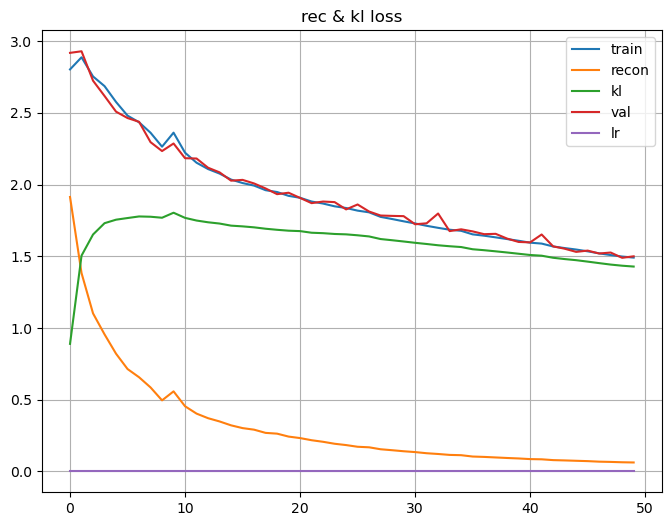

In [14]:
plt.figure(figsize=(8,6))
plt.plot(np.array(history)[:, 0], label='train')
plt.plot(np.array(history)[:, 1], label='recon')
plt.plot(np.array(history)[:, 2], label='kl')
plt.plot(np.array(history)[:, 3], label='val')
plt.plot(np.array(history)[:, 4], label='lr')
plt.title('rec & kl loss')
plt.legend()
plt.grid()
plt.show()

In [36]:
ckpt = {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "history": history,"vocab_size": len(vocab)}
torch.save(ckpt, "trained_models/tcn_vae_baseline_128.pt")

In [ ]:
# ckpt = torch.load("trained_models/tcn_vae_baseline_128.pt", map_location=device)
# model.load_state_dict(ckpt["model_state_dict"])
# optimizer.load_state_dict(ckpt["optimizer_state_dict"])
# history = ckpt["history"]
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=4, factor=0.5, min_lr=1e-5, verbose=True)

In [15]:
logits, mu, logvar = model.encode_sequence(val_data)
z = mu
z = z.cpu().numpy()

### latent PCA

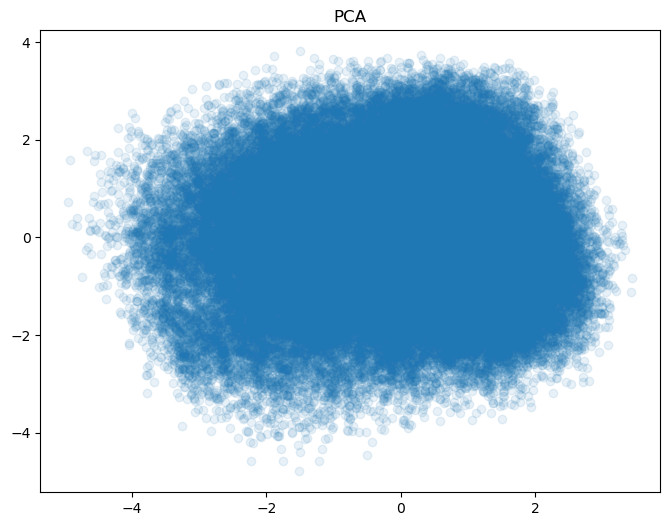

In [17]:
pca_z = PCA(n_components=2).fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(pca_z[:, 0], pca_z[:, 1], alpha=0.1)
plt.title('PCA')
plt.show()

### Testing latent

In [18]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

In [19]:
x = val_data[0:1]
print(x.shape)
logits, mu, logvar = model.encode_sequence(x)
print(logits.shape)
tokens = torch.argmax(logits, dim=-1)
print(tokens_to_selfie(x[0]))
print(tokens_to_selfie(tokens[0]))

(1, 76)
torch.Size([1, 76, 110])
['[C]', '[C]', '[C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[Branch2]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[Ring1]', '[#Branch1]', '[=C]', '[Ring1]', '[O]', '[C]', '[=N]', '[N]', '[Ring2]', '[Ring1]', '[Ring2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['[C]', '[C]', '[C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[=C]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[Ring1]', '[#Branch1]', '[=C]', '[Ring1]', '[O]', '[C]', '[=N]', '[N]', '[Ring2]

In [20]:
def get_accuracy_samples(model, data, pad_id=0, num_samples=5):
    model.eval()    
    for _ in range(num_samples):
        i = np.random.randint(0, len(data))
        x = data[i]
        x = x[np.newaxis, :]
        logits, mu, logvar = model.encode_sequence(x)
        x_rec = torch.argmax(logits, dim=-1)
        acc, pad = 0, 0
        j = 0
        x = x.squeeze(0)
        x_rec = x_rec.squeeze(0)
        while x[j] != pad_id:
            pad += 1
            if x[j] == x_rec[j]:
                acc += 1
            j+=1
        acc = acc / pad
        print(f"real: {tokens_to_selfie(x)}")
        print(f"rec: {tokens_to_selfie(x_rec)}")
        print(f"accuracy: {acc}")
        print('------------------------------')

In [21]:
get_accuracy_samples(model, test_data, pad_id=0, num_samples=5)

real: ['[Cl]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[C]', '[=N]', '[O]', '[C]', '[Branch1]', '[#Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[Cl]', '[N]', '[Ring1]', '[N]', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
rec: ['[Cl]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[C]', '[=N]', '[O]', '[C]', '[Branch1]', '[#Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[Cl]', '[N]', '[Ring1]', '[N]', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '[=C]', '[N]', '[N]', '[#C]

In [22]:
def get_accuracy(model, data, pad_id=0, batch_size=64):
    model.eval()
    all_accs = []
    perfect = 0
    with torch.no_grad():
        for b in range(0, len(data), batch_size):
            batch = data[b : b + batch_size]              
            batch = torch.tensor(batch, device='cuda')  
            logits, mu, logvar = model.encode_sequence(batch)   
            preds = torch.argmax(logits, dim=-1)                
            mask = (batch != pad_id)                            
            correct = (batch == preds) & mask                   
            acc = correct.sum(dim=1).float() / mask.sum(dim=1)
            all_accs.extend(acc.cpu().tolist())
            perfect += (acc == 1).sum().item()
    print(f"reconstructed correctly {perfect} out of {len(data)} molecules")
    print(f"correct rec %: {perfect*100 / len(data):.2f}%")
    print(f"mean accuracy: {np.mean(all_accs)*100:.2f}%")

In [23]:
get_accuracy(model, test_data)

reconstructed correctly 45255 out of 79441 molecules
correct rec %: 56.97%
mean accuracy: 97.80%


### Visualisations

In [24]:
logits, mu, logvar = model.encode_sequence(data)
z = mu
z.cpu().numpy()

array([[-0.2802429 , -0.22704291, -0.8649643 , ...,  0.57708555,
         0.26495942, -0.07317896],
       [-0.44623753, -0.2030279 , -0.2964523 , ...,  0.02889417,
         0.8694501 , -0.39224994],
       [ 0.27758285, -0.4268158 , -1.3557278 , ...,  0.3633414 ,
         0.05769524, -0.65617335],
       ...,
       [-0.34147534,  0.05588815, -1.1234705 , ..., -0.6171627 ,
         0.09648427,  1.402262  ],
       [ 0.14326546, -0.21159907, -0.0518865 , ...,  0.29309022,
         0.05069709,  1.8672692 ],
       [ 0.0148927 ,  0.03764823, -0.4664502 , ..., -0.256366  ,
         0.33405867,  0.54987913]], dtype=float32)

In [25]:
n_samples = 5000
idxs = np.random.choice(z.shape[0], size=n_samples, replace=False)
z_sample = z[idxs]
len_labels = len_labels = np.array(df['lenghts'])[idxs]
z_sample.shape

torch.Size([5000, 128])

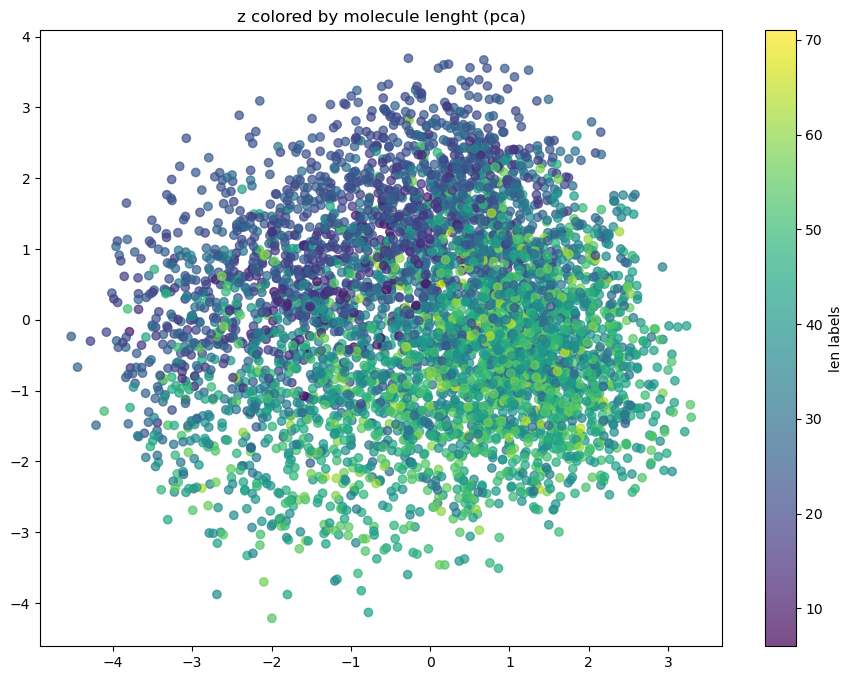

In [26]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')
plt.show()

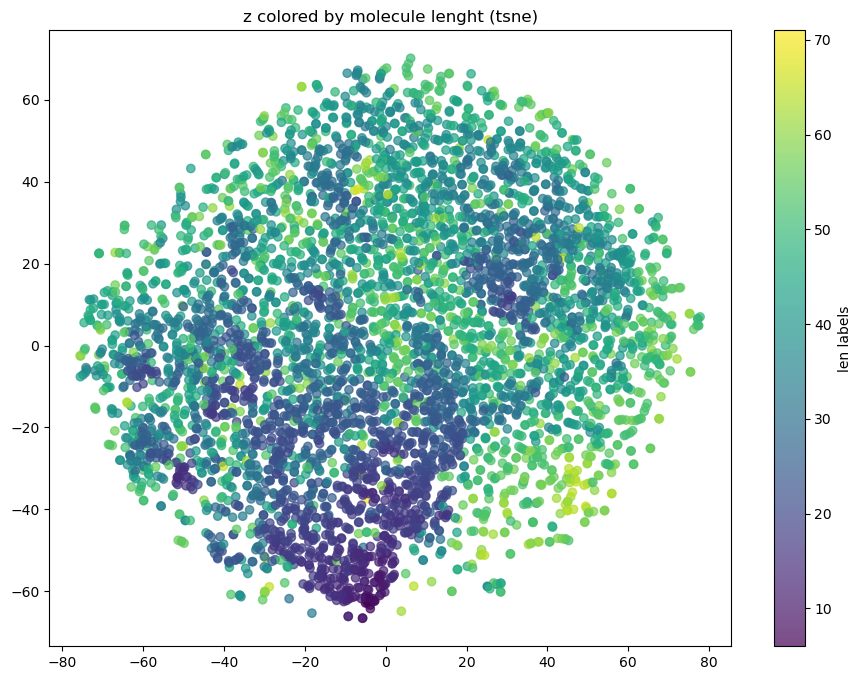

In [27]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (tsne)')
plt.colorbar(label='len labels')
plt.show()

In [28]:
oxygen_labels = df['selfies'].apply(lambda x: 1 if 'O' in x else 0)[idxs]

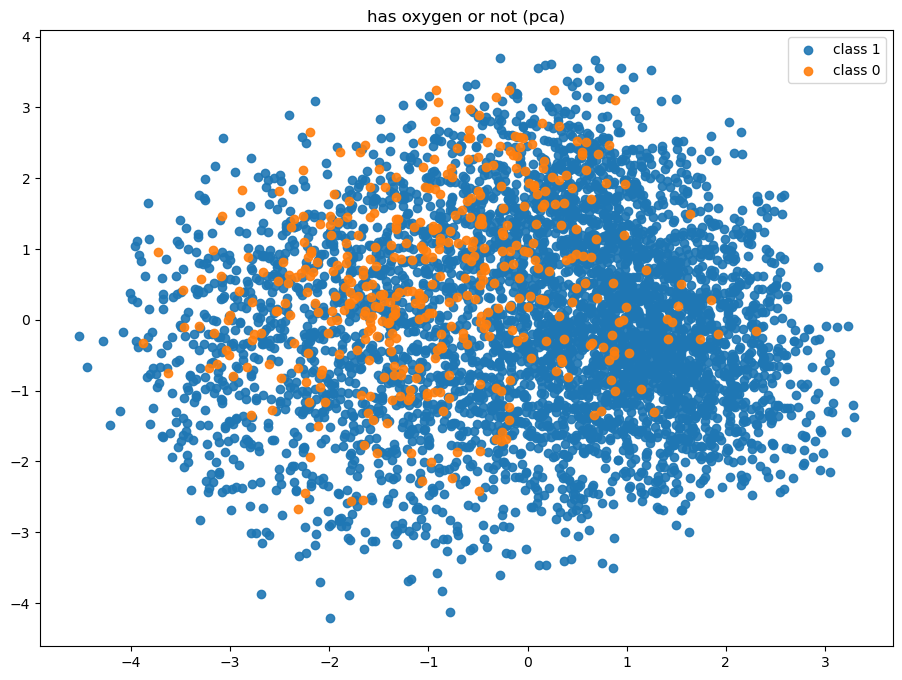

In [29]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

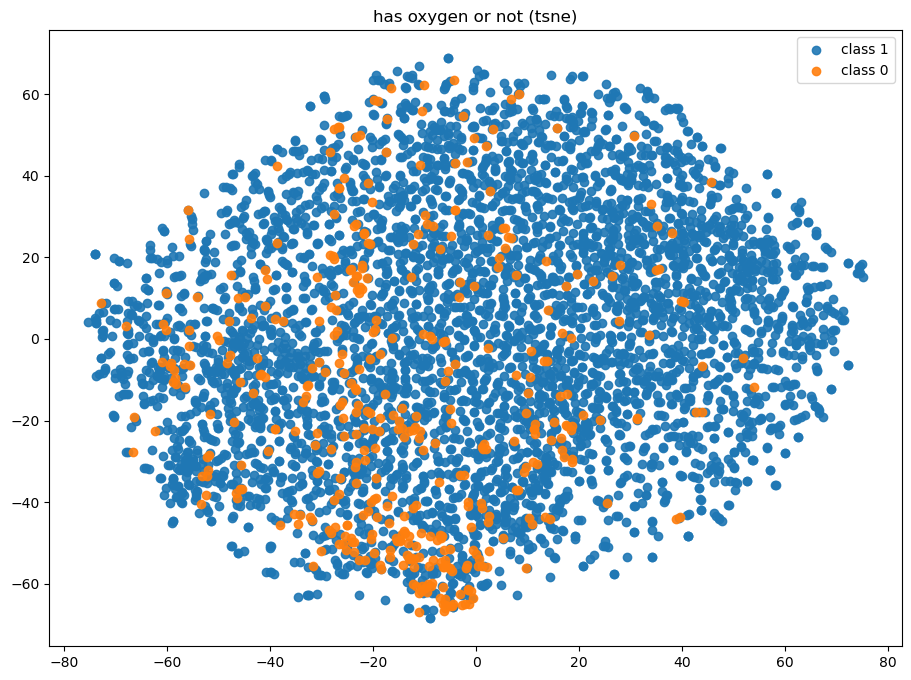

In [30]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (tsne)')
plt.legend()
plt.show()

In [31]:
carbon_label =  df['selfies'].apply(lambda x: x.count('C'))[idxs]

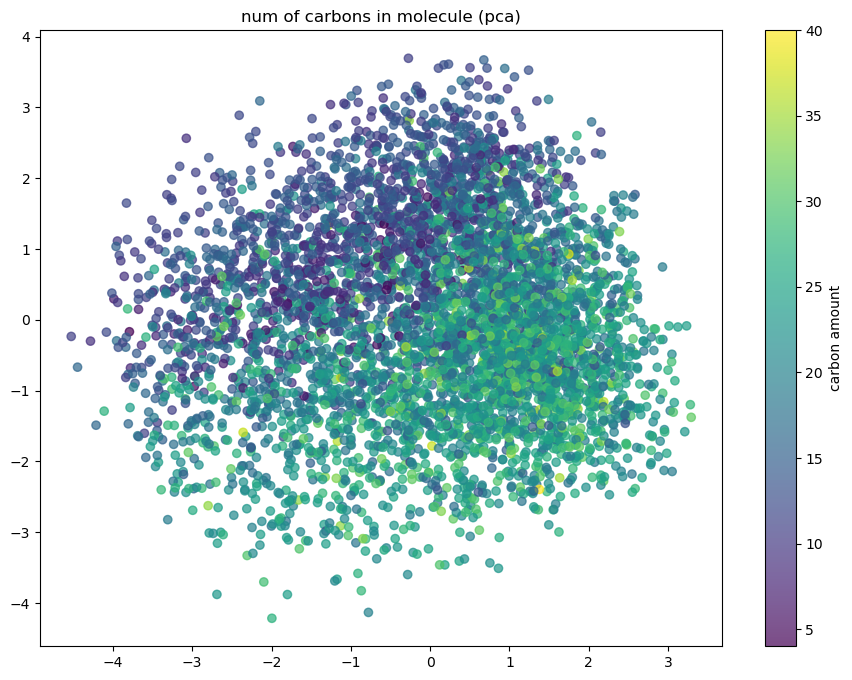

In [32]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (pca)')
plt.colorbar(label='carbon amount')
plt.show()

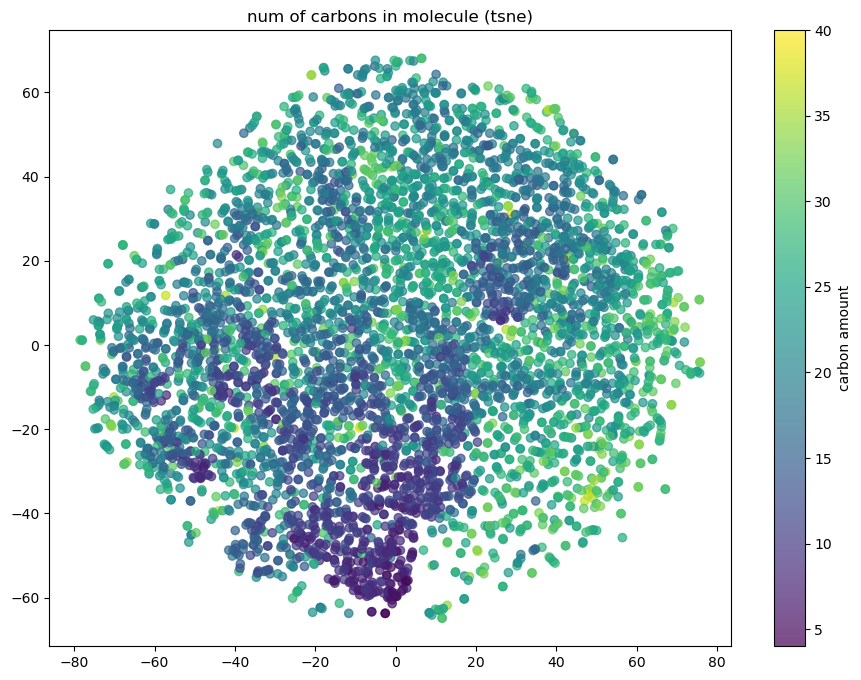

In [33]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (tsne)')
plt.colorbar(label='carbon amount')
plt.show()

### Check validity of Latent Space

In [129]:
def sample_and_check(model, latent_size=128, n=1000):
    z = torch.randn((n, latent_size), device='cuda')
    with torch.no_grad():
        model.eval()
        logits = model.decode(z)
    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    valid_mask = np.zeros(n)
    valid_molecules = []
    for tokens in preds:
        selfie = tokens_to_selfie(tokens)
        selfie = "".join(selfie).replace("<PAD>", "")
        try:
            smiles = sf.decoder(selfie)
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                valid_mask[i] = 1
            valid_molecules.append(smiles)
            print('valid')
        except:
            pass
    return z, valid_mask, valid_molecules

In [132]:
z, valid_mask, valid_molecules = sample_and_check(model)
print(f'valid molecules %:{valid_mask.sum() / len(valid_mask)}')
z = z.cpu().numpy()

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 0 has a total capacity of 7.63 GiB of which 42.62 MiB is free. Including non-PyTorch memory, this process has 7.57 GiB memory in use. Of the allocated memory 7.40 GiB is allocated by PyTorch, and 31.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [131]:
torch.cuda.empty_cache()

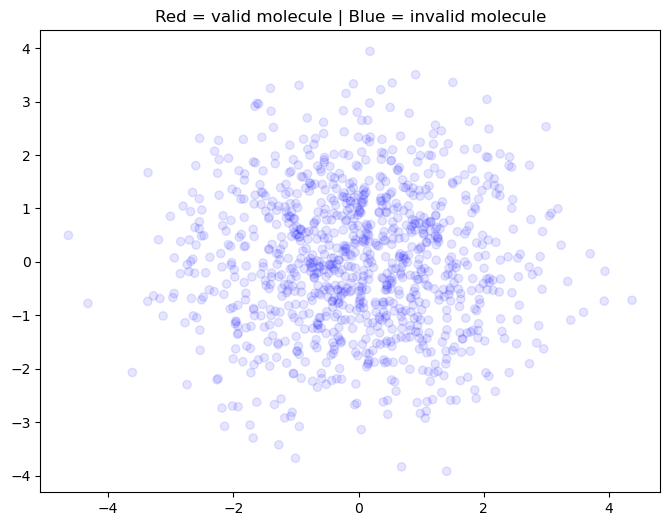

In [133]:
pca_z = PCA(n_components=2).fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=valid_mask, cmap='bwr', alpha=0.1)
plt.title('Red = valid molecule | Blue = invalid molecule')
plt.show()

In [184]:
def cleaned_selfie(tokens):
    cleaned = []
    for tok in tokens:
        if tok == "<EOS>":
            break
        else:
            cleaned.append(tok)
    return cleaned

In [186]:
def latent_traversal(model, x, dim=0, steps=40, max_delta=3.0):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(x.unsqueeze(0).to(device))
    z = mu[0]
    xs = np.linspace(-max_delta, max_delta, steps)
    zs = []
    valids = []

    for s in xs:
        z_new = z.clone()
        z_new[dim] += s
        logits = model.decode(z_new.unsqueeze(0))
        ids = logits.argmax(dim=-1)[0].cpu().numpy()

        toks = [id2tok[t] for t in ids]
        toks = cleaned_selfie(toks)
        selfies_str = "".join(toks).replace("<PAD>", "")
        zs.append(z_new.cpu().numpy())

        try:
            smiles = sf.decoder(selfies_str)
            print(smiles)
            valids.append(Chem.MolFromSmiles(smiles) is not None)
        except:
            valids.append(False)

    plt.plot(xs, valids)
    plt.title(f"Validity when traversing latent dim={dim}")
    plt.show()
    pca_z = PCA(n_components=2).fit_transform(zs)
    plt.scatter(pca_z[:, 0], pca_z[:, 1], c=valids, cmap='bwr')
    plt.show()

CCOC(=O)C=1C2=C(OC)NC(=O)CC=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=O)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=O)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=O)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=O)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=O)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=O)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=O)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=N)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=N)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=N)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=N)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=N)[NH1]C=C2C=1
CCOC(=O)C=1C2=C(OC)NC(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(OC)N2C(=N)[NH1]C=C2C=1
CCOC(=O)C=1C=C(O

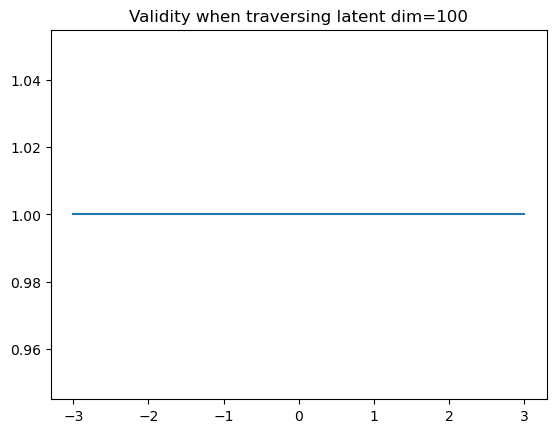

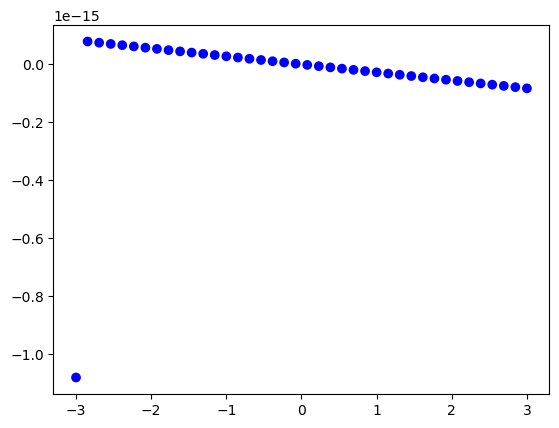

In [189]:
latent_traversal(model, torch.tensor(train_data[np.random.randint(0,len(train_data))]), dim=100, steps=40, max_delta=3)

In [210]:
def latent_random_traversal(model, x, steps=40, sigma=0.1):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(x.unsqueeze(0).to(device))
    z = mu
    
    logits = model.decode(z.unsqueeze(0))
    ids = logits.argmax(dim=-1)[0].cpu().numpy()
    toks = [id2tok[t] for t in ids]
    toks = cleaned_selfie(toks)
    selfies_str = "".join(toks).replace("<PAD>", "")
    smiles = sf.decoder(selfies_str)
    print(f'start smiles: {smiles}')
    try:
        smiles = sf.decoder(selfies_str)
        if Chem.MolFromSmiles(smiles) is not None:
            print('start smile is valid')
    except:
        print('start smile is not valid')

    zs = []
    valids = []

    z_new = z.clone()
    for s in range(steps):
        z_new += torch.randn_like(z_new) * sigma
        logits = model.decode(z_new.unsqueeze(0))
        ids = logits.argmax(dim=-1)[0].cpu().numpy()

        toks = [id2tok[t] for t in ids]
        selfies_str = "".join(toks).replace("<PAD>", "")
        zs.append(z_new.squeeze_(0).cpu().numpy())

        try:
            smiles = sf.decoder(selfies_str)
            print(smiles)
            valids.append(Chem.MolFromSmiles(smiles) is not None)
        except:
            #smiles = sf.decoder(selfies_str)
            valids.append(False)

    plt.plot(np.arange(steps), valids)
    plt.title(f"Validity when random traversing")
    plt.show()
    print(zs[0].shape)
    pca_z = PCA(n_components=2).fit_transform(zs)
    plt.scatter(pca_z[:, 0], pca_z[:, 1], c=valids, cmap='bwr')
    plt.show()

start smiles: C1=C[C@@H1]2C[C@@H1]1CN2CC3=CC=CC=C3
start smile is valid
C1=CCCC[C@@H1]1C
C1=CCCC[C@@H1]1C
C1#CCCC[C@@H1]1N
C1#CCCC[C@@H1]1N


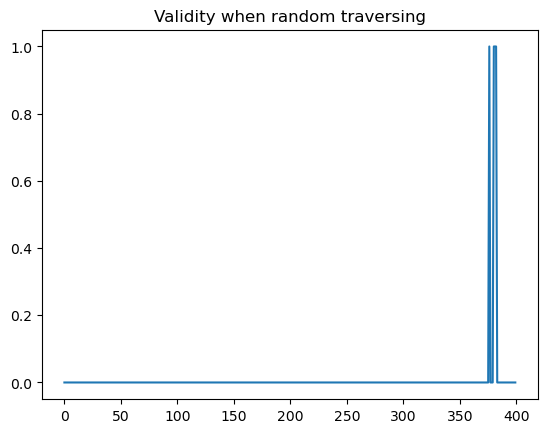

(128,)


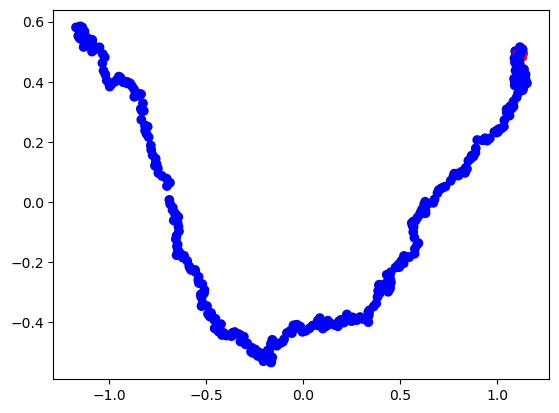

In [211]:
latent_random_traversal(model, torch.tensor(train_data[np.random.randint(0,len(train_data))]), steps=400, sigma=0.01)